# Predicting Flight Delays

We have a large data set (7 million points) of flight arrivals in 2008. Can we predict how much a flight will be delayed before it takes off? Let's take a look.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime

%matplotlib inline
sns.set_style('white')

In [119]:
raw_data = pd.read_csv('2008.csv').sample(frac=0.1)
len(raw_data)

700973

In [120]:
data_clean = raw_data.reset_index(drop=True)
data_clean.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,8,26,2,1935.0,1900,2245.0,2215,F9,372,...,5.0,13.0,0,NaN,0,0.0,0.0,0.0,0.0,30.0
1,2008,1,26,6,1222.0,1200,1356.0,1335,AA,1102,...,6.0,9.0,0,NaN,0,7.0,0.0,0.0,0.0,14.0
2,2008,3,26,3,1930.0,1936,2105.0,2116,OH,5231,...,20.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,11,10,1,1457.0,1438,1826.0,1811,FL,677,...,7.0,8.0,0,NaN,0,0.0,0.0,0.0,0.0,15.0
4,2008,12,7,7,1459.0,1500,1743.0,1810,AA,2371,...,9.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


First of all, I'm going to convert Year, Month, and DayofMonth to DayOfYear. This should capture holidays better than the features separately.

In [121]:
data_clean['DayOfYear'] = [datetime.datetime(
    data_clean.loc[row, 'Year'], 
    data_clean.loc[row, 'Month'], 
    data_clean.loc[row, 'DayofMonth']).timetuple().tm_yday for row in range(len(raw_data))]

In [122]:
data_clean['DayOfYear'].head()

0    239
1     26
2     86
3    315
4    342
Name: DayOfYear, dtype: int64

In [123]:
data_clean.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)
data_clean.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfYear
0,2,1935.0,1900,2245.0,2215,F9,372,N926FR,130.0,135.0,...,13.0,0,NaN,0,0.0,0.0,0.0,0.0,30.0,239
1,6,1222.0,1200,1356.0,1335,AA,1102,N3BFAA,94.0,95.0,...,9.0,0,NaN,0,7.0,0.0,0.0,0.0,14.0,26
2,3,1930.0,1936,2105.0,2116,OH,5231,N625CA,95.0,100.0,...,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,86
3,1,1457.0,1438,1826.0,1811,FL,677,N894AT,149.0,153.0,...,8.0,0,NaN,0,0.0,0.0,0.0,0.0,15.0,315
4,7,1459.0,1500,1743.0,1810,AA,2371,N4XBAA,224.0,250.0,...,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,342


In [124]:
data_clean.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode',
       'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'DayOfYear'],
      dtype='object')

What are we actually trying to predict with this data set? 

**How late will a flight be?**

The variable for this is "ArrDelay"

Great, but that also means there's a lot of data in there that we can't actually use. Specifically, CarrierDelay through LateAircraftDelay are all a breakdown of WHY we're late. They contain the output variable, and can't be used predictively. Same with ArrTime, AirTime, TaxiIn, and ActualElapsedTime. Cancelled, Diverted, and TaxiOut are sketchy because they aren't known ahead of time. Similarly, DepDelay and DepTime are only known once the flight takes off. If our goal is to predict BEFORE a flight leaves the ground, then these are out as well. Let's see what we're left with.

In [125]:
data_clean.drop(['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 
                 'DepDelay', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 
                 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                 'LateAircraftDelay'], axis=1, inplace=True)

In [126]:
data_clean.columns

Index(['DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'CRSElapsedTime', 'ArrDelay', 'Origin', 'Dest', 'Distance',
       'DayOfYear'],
      dtype='object')

We should be able to safely dropna() now that most of the offending columns are gone.

In [127]:
data_clean.dropna(inplace=True)
data_clean.describe()

,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,Distance,DayOfYear
count,685839.000000,685839.000000,685839.000000,685839.000000,685839.000000,685839.000000,685839.000000,685839.000000
mean,3.928903,1324.798743,1493.729100,2214.088008,129.013694,8.169608,728.064884,179.533606
std,1.988370,463.989893,482.408914,1956.603901,69.382894,38.534371,561.958491,104.010013
min,1.000000,1.000000,0.000000,1.000000,12.000000,-86.000000,24.000000,1.000000
25%,2.000000,925.000000,1115.000000,620.000000,80.000000,-10.000000,328.000000,90.000000
50%,4.000000,1316.000000,1515.000000,1566.000000,111.000000,-2.000000,581.000000,178.000000
75%,6.000000,1715.000000,1905.000000,3492.000000,159.000000,12.000000,954.000000,268.000000
max,7.000000,2359.000000,2359.000000,9741.000000,660.000000,1290.000000,4962.000000,366.000000


In [128]:
data_clean.shape

(685839, 12)

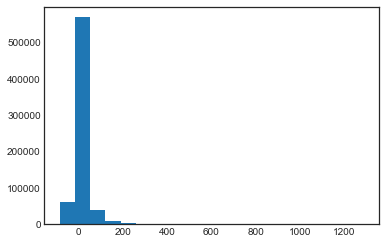

In [129]:
plt.hist(data_clean.ArrDelay, bins=20)
plt.show()

In [130]:
data_clean.ArrDelay.describe()

count    685839.000000
mean          8.169608
std          38.534371
min         -86.000000
25%         -10.000000
50%          -2.000000
75%          12.000000
max        1290.000000
Name: ArrDelay, dtype: float64

There are some major outliers here. Let's reduce all the values over 250 minutes late to 250.

In [131]:
data_clean[data_clean.ArrDelay>250].ArrDelay.count()

2054

In [132]:
data_clean.loc[data_clean.ArrDelay>250, 'ArrDelay'] = 250

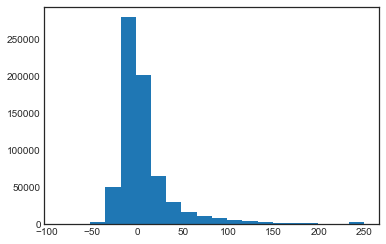

In [133]:
plt.hist(data_clean.ArrDelay, bins=20)
plt.show()

FlightNum and TailNum are categorical variables, so let's remove them for now. We're not going to make dummies for every single plane (although it might be interesting if we had the processing power).

In [134]:
data_clean.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

In [135]:
data_clean.UniqueCarrier.unique()

array(['F9', 'AA', 'OH', 'FL', 'MQ', 'AS', 'DL', 'WN', 'NW', 'OO', 'XE',
       'CO', 'YV', 'US', 'EV', '9E', 'UA', 'HA', 'AQ', 'B6'], dtype=object)

This one we can make dummies for. Also Origin and Dest (although this will give us a lot of features!). We'll be sure to run feature selection before we run our models.

In [136]:
pd.get_dummies(data_clean).shape

(685839, 630)

In [137]:
data_clean = pd.get_dummies(data_clean)

In [138]:
# Data is already shuffled.

test_frac = 0.1
test_size = int(test_frac*len(data_clean))

data_train = data_clean[test_size:]
data_test = data_clean[:test_size]

data_train.shape, data_test.shape

((617256, 630), (68583, 630))

In [139]:
X_train = data_train.loc[:, ~data_train.columns.isin(['ArrDelay'])]
Y_train = data_train['ArrDelay']

X_test = data_test.loc[:, ~data_test.columns.isin(['ArrDelay'])]
Y_test = data_test['ArrDelay']

In [63]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE

In [140]:
skb = SelectKBest(k=100)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

In [65]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [141]:
lnr = LinearRegression()
lnr.fit(X_train_skb,Y_train)
lnr.score(X_test_skb,Y_test)

0.038212150587901395

In [80]:
rid = Ridge(alpha=10)
rid.fit(X_train_skb,Y_train)
rid.score(X_test_skb,Y_test)

0.035516250711118968

In [84]:
las = Lasso(alpha=0.1)
las.fit(X_train_skb,Y_train)
las.score(X_test_skb,Y_test)

0.030297340938615355

In [88]:
knr = KNeighborsRegressor(n_neighbors=3)
knr.fit(X_train_skb,Y_train)
knr.score(X_test_skb,Y_test)

-0.25280929910042915

In [93]:
dtr = DecisionTreeRegressor(max_depth=10, max_features=4)
dtr.fit(X_train_skb,Y_train)
dtr.score(X_test_skb,Y_test)

0.012072647378456924

In [142]:
rfr = RandomForestRegressor(n_estimators=20, max_depth=10)
rfr.fit(X_train_skb,Y_train)
rfr.score(X_test_skb,Y_test)

0.10858612729414607

In [100]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3)
gbr.fit(X_train_skb,Y_train)
gbr.score(X_test_skb,Y_test)

0.072236996066485371

In [101]:
# This one takes a long time -- beware when using a large fraction of the data set!
#svr = SVR(C=1)
#svr.fit(X_train_skb,Y_train)
#svr.score(X_test_skb,Y_test)

-0.077917858590535349

Yikes -- Nothing is really working on this. With 70,000 data points, I'm topping out at 0.07 R^2 on the test set.

I reran the RFR model with 10x as much data -- 700,000 points. R^2 = 0.11. 

In [143]:
Y_pred = rfr.predict(X_test_skb)

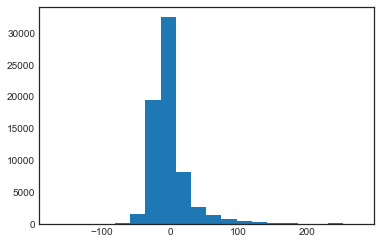

In [144]:
plt.hist((Y_test-Y_pred), bins=20)
plt.show()

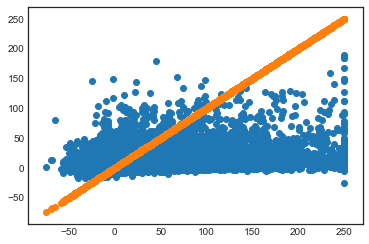

In [147]:
plt.scatter(Y_test, Y_pred)
plt.scatter(Y_test, Y_test)
plt.show()

Doesn't look so good...